#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/KT_AI_MiniProject_1_Practice/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
# 주어진 데이터 셋을 불러오세요.(3개)
train_data_set = pd.read_csv(path + 'data01_train.csv')
test_data_set = pd.read_csv(path + 'data01_test.csv')
features = pd.read_csv(path + 'features.csv')

In [6]:
#불필요한 칼럼을 삭제하세요.
train_data_set.drop('subject', axis=1, inplace=True)

In [7]:
test_data_set.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [8]:
#전체 데이터의 행,열 개수 확인
print(train_data_set.shape, test_data_set.shape)

(5881, 562) (1471, 562)


In [9]:
#전체 데이터의 상위 5개 행 확인
train_data_set.head(5)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [10]:
#전체 데이터의 수치형 변수 분포 확인
train_data_set.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [11]:
#전체 데이터의 모든 변수 확인
train_data_set.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [12]:
# 데이터 분할을 합니다.
x = train_data_set.drop('Activity', axis=1)
y = train_data_set['Activity']

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [13]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [14]:
x_scaled

array([[0.52687771, 0.40103261, 0.4483189 , ..., 0.20172526, 0.90064712,
        0.5783957 ],
       [0.5117488 , 0.39665284, 0.45091831, ..., 0.68030897, 0.15614974,
        0.42027184],
       [0.52036187, 0.397878  , 0.44564134, ..., 0.08417169, 0.8134681 ,
        0.47844432],
       ...,
       [0.51322808, 0.39560096, 0.44628003, ..., 0.81946438, 0.38071249,
        0.20619865],
       [0.4765254 , 0.37792494, 0.43949969, ..., 0.14261102, 0.87464056,
        0.50757095],
       [0.52375729, 0.38235978, 0.43099098, ..., 0.13136594, 0.68216407,
        0.4211814 ]])

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [15]:
# 정수 인코딩 변환(LabelEncoder)
le = LabelEncoder()
y_le = le.fit_transform(y)
y

,Activity
0,STANDING
1,LAYING
2,STANDING
3,WALKING
4,WALKING_DOWNSTAIRS
...,...
5876,SITTING
5877,WALKING_UPSTAIRS
5878,LAYING
5879,WALKING_UPSTAIRS


In [16]:
y_le

array([2, 0, 2, ..., 0, 5, 1])

In [17]:
# 기존 레이블 저장
label_classes = le.classes_
label_classes

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [18]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y_train, y_val = train_test_split(x_scaled, y_le, train_size=0.75, random_state=20)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [19]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [20]:
input_size = x_train.shape[1]
output_size = label_classes.shape[0]
print(input_size, output_size)

561 6


In [21]:
model = Sequential([
    Dense(input_size, activation="relu"),
    Dense(output_size, activation="softmax")
])

In [22]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [23]:
history = model.fit(
    x_train, y_train,
    batch_size = 4,
    epochs=10,
    validation_data=(x_val, y_val)  # 미리 분리해둔 검증셋
)

Epoch 1/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7371 - loss: 0.6383 - val_accuracy: 0.9273 - val_loss: 0.1911
Epoch 2/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9249 - loss: 0.1893 - val_accuracy: 0.9273 - val_loss: 0.1796
Epoch 3/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9423 - loss: 0.1602 - val_accuracy: 0.9232 - val_loss: 0.1774
Epoch 4/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9514 - loss: 0.1265 - val_accuracy: 0.9592 - val_loss: 0.1104
Epoch 5/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9596 - loss: 0.1190 - val_accuracy: 0.9728 - val_loss: 0.0720
Epoch 6/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9610 - loss: 0.1037 - val_accuracy: 0.9415 - val_loss: 0.1437
Epoch 7/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9589 - loss: 0.1009 - val_accuracy: 0.9735 - val_loss: 0.0684
Epoch 8/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9635 - loss: 0.0970 - 

In [24]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

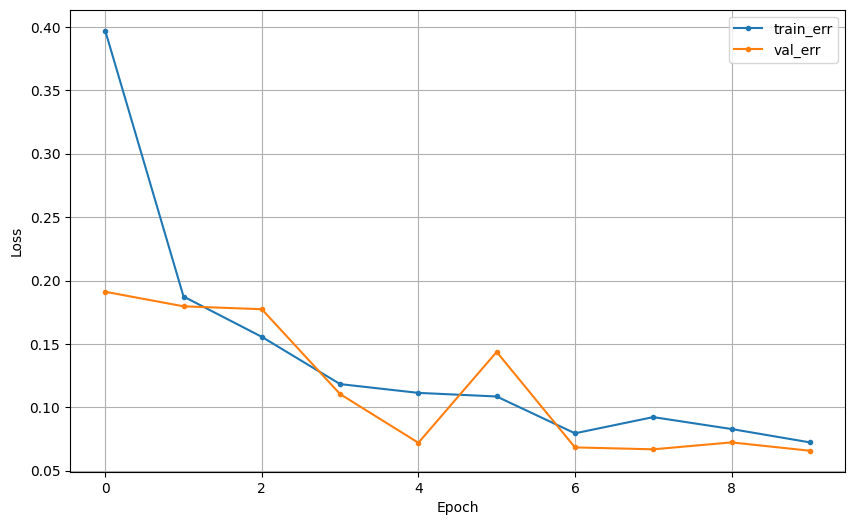

In [25]:
# 학습곡선
dl_history_plot(history.history)

In [26]:
# 예측 및 평가
test_x = test_data_set.drop('Activity', axis=1)
test_y = test_data_set['Activity']
test_x_scaled = scaler.transform(test_x)
test_y_le = le.transform(test_y)

In [27]:
y_predict = model.predict(test_x_scaled)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [28]:
test_loss, test_acc = model.evaluate(test_x_scaled, test_y_le)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9708 - loss: 0.0733
Test Loss: 0.07477185130119324
Test Accuracy: 0.9707682132720947


In [29]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!
test_loss_hist = []
test_acc_hist = []
for i in range(5):
  test_loss, test_acc = model.evaluate(test_x_scaled, test_y_le)
  test_loss_hist.append(test_loss)
  test_acc_hist.append(test_acc)
print("Test Loss:", np.mean(test_loss_hist))
print("Test Accuracy:", np.mean(test_acc_hist))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9708 - loss: 0.0733
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9708 - loss: 0.0733
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9708 - loss: 0.0733
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9708 - loss: 0.0733
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9708 - loss: 0.0733
Test Loss: 0.07477185130119324
Test Accuracy: 0.9707682132720947


### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [30]:
# 모델 설계
model2 = Sequential([
    Dense(input_size, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(output_size, activation="softmax")
])

In [31]:
# 컴파일 및 학습
model2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [32]:
history2 = model2.fit(
    x_train, y_train,
    batch_size = 4,
    epochs=10,
    validation_data=(x_val, y_val)  # 미리 분리해둔 검증셋
)

Epoch 1/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6120 - loss: 0.8710 - val_accuracy: 0.9103 - val_loss: 0.2242
Epoch 2/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8597 - loss: 0.3598 - val_accuracy: 0.9211 - val_loss: 0.1986
Epoch 3/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9103 - loss: 0.2395 - val_accuracy: 0.9497 - val_loss: 0.1270
Epoch 4/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9326 - loss: 0.1748 - val_accuracy: 0.9252 - val_loss: 0.2575
Epoch 5/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9493 - loss: 0.1397 - val_accuracy: 0.9130 - val_loss: 0.2315
Epoch 6/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9367 - loss: 0.1606 - val_accuracy: 0.9701 - val_loss: 0.0795
Epoch 7/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9505 - loss: 0.1295 - val_accuracy: 0.9415 - val_loss: 0.1401
Epoch 8/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9587 - loss: 0.1231 -

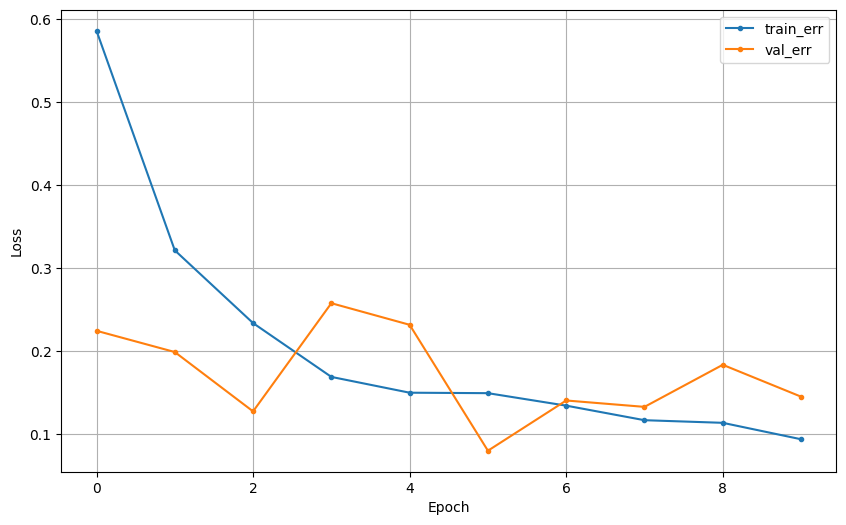

In [33]:
# 학습곡선
dl_history_plot(history2.history)

In [34]:
# 예측 및 평가
test_loss, test_acc = model2.evaluate(test_x_scaled, test_y_le)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9493 - loss: 0.1392
Test Loss: 0.16279061138629913
Test Accuracy: 0.9394969344139099


In [35]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!
test_loss_hist = []
test_acc_hist = []
for i in range(5):
  test_loss, test_acc = model2.evaluate(test_x_scaled, test_y_le)
  test_loss_hist.append(test_loss)
  test_acc_hist.append(test_acc)
print("Test Loss:", np.mean(test_loss_hist))
print("Test Accuracy:", np.mean(test_acc_hist))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9493 - loss: 0.1392
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9493 - loss: 0.1392
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9493 - loss: 0.1392
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9493 - loss: 0.1392
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9493 - loss: 0.1392
Test Loss: 0.16279061138629913
Test Accuracy: 0.9394969344139099


### (3) 모델3 : 학습률, epoch 등 조정

In [36]:
# 모델 설계
model3 = Sequential([
    Dense(input_size, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(output_size, activation="softmax")
])

In [37]:
# learning rate 조정
optimizer = Adam(learning_rate=0.05)

In [38]:
# 컴파일 및 학습
model3.compile(
    optimizer = optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [39]:
history3 = model3.fit(
    x_train, y_train,
    batch_size = 4,
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3258 - loss: 2.5161 - val_accuracy: 0.3467 - val_loss: 1.1539
Epoch 2/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3354 - loss: 1.1543 - val_accuracy: 0.3222 - val_loss: 1.1321
Epoch 3/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3383 - loss: 1.1498 - val_accuracy: 0.3270 - val_loss: 1.1863
Epoch 4/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3458 - loss: 1.1324 - val_accuracy: 0.3331 - val_loss: 1.1169
Epoch 5/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3422 - loss: 1.1420 - val_accuracy: 0.3467 - val_loss: 1.1165
Epoch 6/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3525 - loss: 1.1500 - val_accuracy: 0.3243 - val_loss: 1.1179
Epoch 7/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3237 - loss: 1.1361 - val_accuracy: 0.3467 - val_loss: 1.1390
Epoch 8/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3405 - loss: 1.1379 - 

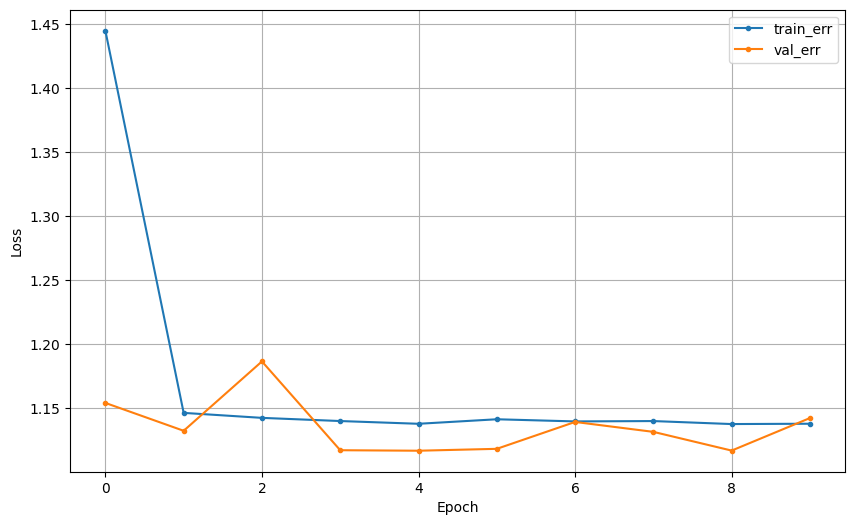

In [40]:
# 학습곡선
dl_history_plot(history3.history)

In [41]:
# 예측 및 평가
test_loss_hist = []
test_acc_hist = []
for i in range(5):
  test_loss, test_acc = model3.evaluate(test_x_scaled, test_y_le)
  test_loss_hist.append(test_loss)
  test_acc_hist.append(test_acc)
print("Test Loss:", np.mean(test_loss_hist))
print("Test Accuracy:", np.mean(test_acc_hist))

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3501 - loss: 1.1508
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3501 - loss: 1.1508
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3501 - loss: 1.1508
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3501 - loss: 1.1508
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3501 - loss: 1.1508
Test Loss: 1.1501048803329468
Test Accuracy: 0.3412644565105438


### (4) 모델4 :  학습률, epoch 등 조정

In [47]:
# 모델 설계
model4 = Sequential([
    Dense(input_size, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(output_size, activation="softmax")
])

In [48]:
# 컴파일 및 학습
optimizer4 = Adam(learning_rate=0.005)
model4.compile(
    optimizer=optimizer4,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [49]:
history4 = model4.fit(
    x_train, y_train,
    batch_size = 4,
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4646 - loss: 1.1040 - val_accuracy: 0.6254 - val_loss: 0.7063
Epoch 2/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6623 - loss: 0.6767 - val_accuracy: 0.7988 - val_loss: 0.4757
Epoch 3/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7569 - loss: 0.5224 - val_accuracy: 0.8212 - val_loss: 0.4447
Epoch 4/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8101 - loss: 0.4771 - val_accuracy: 0.9177 - val_loss: 0.2428
Epoch 5/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8930 - loss: 0.3007 - val_accuracy: 0.9109 - val_loss: 0.2604
Epoch 6/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6767 - loss: 0.7797 - val_accuracy: 0.8280 - val_loss: 0.3796
Epoch 7/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8776 - loss: 0.3447 - val_accuracy: 0.9137 - val_loss: 0.2373
Epoch 8/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8894 - loss: 0.3141 - 

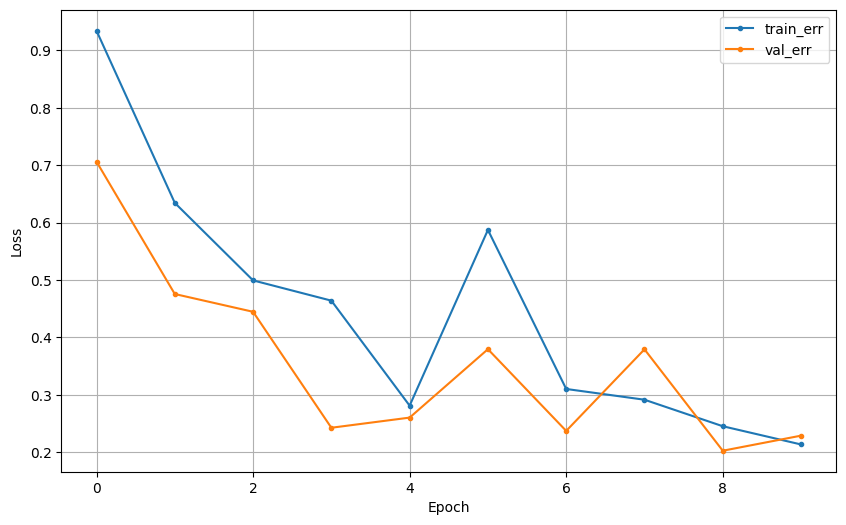

In [50]:
# 학습곡선
dl_history_plot(history4.history)

In [51]:
# 예측 및 평가
test_loss_hist = []
test_acc_hist = []
for i in range(5):
  test_loss, test_acc = model4.evaluate(test_x_scaled, test_y_le)
  test_loss_hist.append(test_loss)
  test_acc_hist.append(test_acc)
print("Test Loss:", np.mean(test_loss_hist))
print("Test Accuracy:", np.mean(test_acc_hist))

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9259 - loss: 0.4214
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9259 - loss: 0.4214
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9259 - loss: 0.4214
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9259 - loss: 0.4214
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9259 - loss: 0.4214
Test Loss: 0.31736189126968384
Test Accuracy: 0.9204622507095337


## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [ ]:
#전체 데이터 불러오기(test)

# subject 삭제

# x, y 분할

# x : 스케일링 적용

# y : 정수인코딩 적용

In [ ]:
# test 데이터에 대한 성능 측정

#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.